# 10. Predicting Continuous Target Variables with Regression Analysis 

In [1]:
from IPython.display import Image

Regression models은 연속적인 값을 가지는 변수를 예측한다. 예를 들어 변수 간의 관계 이해, 트렌드 평가, 예측 등이다.

## Topics 

- Exploring and visualizing datasets
- Looking at different approaches to implement linear regression models
- Training regression models that are robust to outliers
- Evaluating regression models and diagnosing common problems
- Fitting regression models to nonlinear data

## Introducing a simple linear regression model 

simple linear regression의 목표는 단일 설명 변수 x와 연속적 값인 목표 변수 y와의 관계를 모델링하는 것이다.

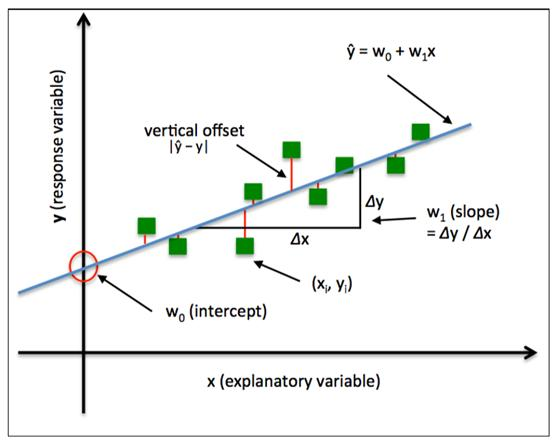

In [2]:
Image(filename='./image/image1.jpg', width=600) 

## Exploring the Housing Dataset  

이 모델에서 사용할 변수들

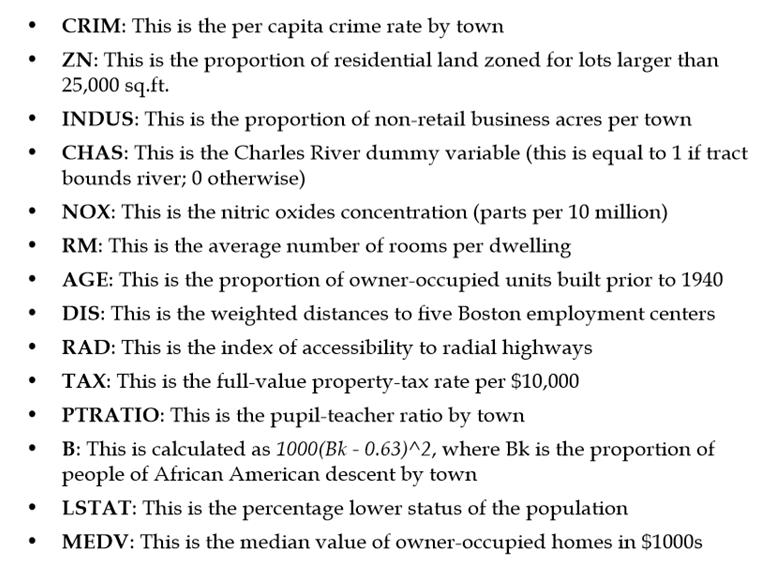

In [3]:
Image(filename='./image/image2.jpg', width=600) 

###  데이터프레임 선언

In [4]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Visualizing the Important characteristics of a dataset 

EDA(Exploratory Data Analysis)는 머신러닝 모델을 트레이닝 시키기 전에 추천되는 첫번째 스텝이며 매우 중요하다!

우리는 graphical EDA toolbox로부터 아주 간단하지만 유용한 방법으로 아웃라이어의 존재를 파악하거나 데이터의 분포, feature들 간의 관계를 알아낼 것이다.

#### 1. Scatterplot matrix

이는 다른 feature들 간의 상관관계를 pair-wise하게 visualize해준다.

C:\Users\성동\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Users\성동\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


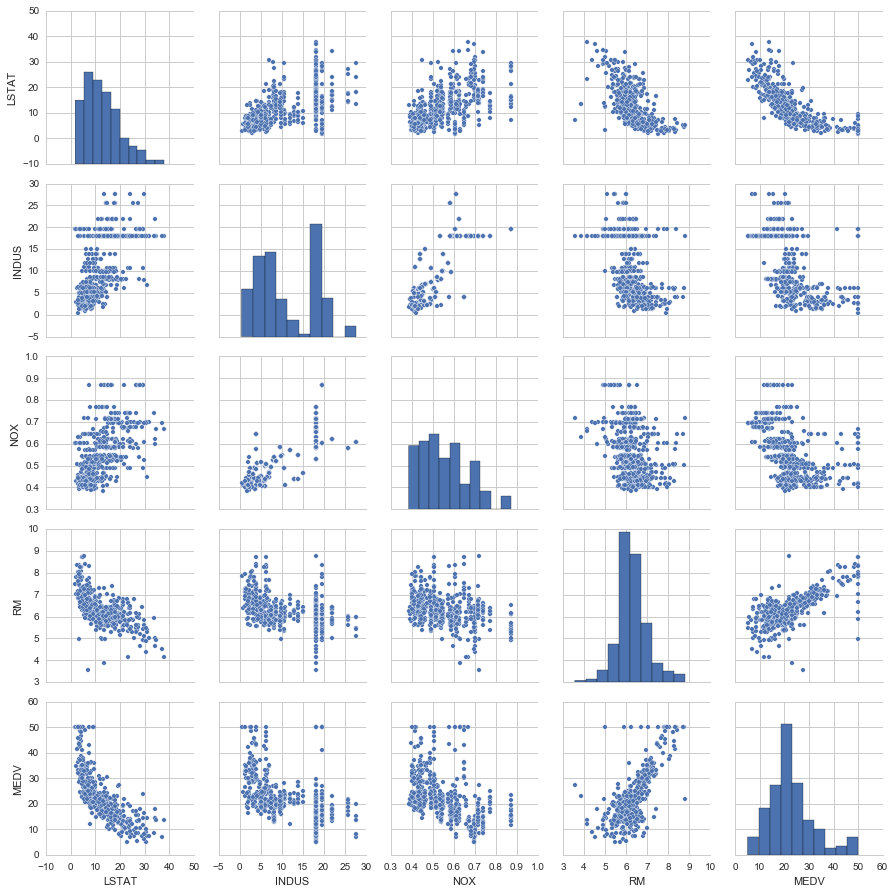

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_orig()
%matplotlib inline

sns.set(style = 'whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV'] # 임의로 뽑은 것. 원한다면 다른 것들도 그려봐라
sns.pairplot(df[cols], size=2.5);
plt.show()

위 그림으로부터 우리는 데이터셋의 관계에 대한 그래피컬한 요약을 얻을 수 있다.

일반적 믿음과는 달리, linear regression을 트레이닝 시키는데 설명 변수나 목표 변수가 꼭 정규 분포를 따라야 할 필요는 없다. 정상성에 대한 가정은 오직 특정 통계 실험과 가정 검정에 요구된다.

위의 그래프에서 시각적으로 변수 간의 관계를 알아보았다면 수치적으로 나타내기 위해 correlation matrix를 사용할 수도 있다. 이는 4장에서 설명했었음.

C:\Users\성동\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


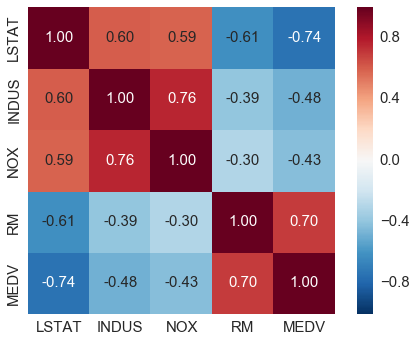

In [6]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

우리는 우리의 Target인 MEDV 와 나머지 변수와의 상관관계에 관심이 있다. LSTAT과는 음의 상관관계를 RM과는 양의 상관관계를 가진다는 것을 위의 히트맵으로 분명히 알 수 있다. 하지만 scatterplot에서 봤었지만 LSTAT과 MEDV는 비선형적인 관계를 가진다는 것을 알 수 있다. 하지만 RM과는 선형적인 관계를 가지기 때문에 설명 변수로 적합하다는 것을 알 수 있다.

### Implementing an ordinary least squares linear regression model 

### Solving regression for regression parameters with gradient descent 

2장에서 살펴 보았던 Adaline을 통해 싱글 뉴런의 linear 액티베이션 펑션을 통해 코스트를 정의할 수 있다. 이는 SSE(Sum of Squared Error)이며 OLS의 cost와 동일하다.

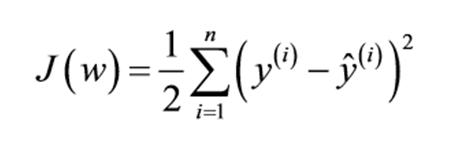

In [7]:
Image(filename='./image/image3.jpg', width=600) 

In [7]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20): # eta 학습률, n_iter 이터레이션 수
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):        
        self.w_ = np.zeros(1 + X.shape[1])        
        self.cost_ = []
        for i in range(self.n_iter):            
            output = self.net_input(X)            
            errors = (y - output)            
            self.w_[1:] += self.eta * X.T.dot(errors)            
            self.w_[0] += self.eta * errors.sum()            
            cost = (errors**2).sum() / 2.0            
            self.cost_.append(cost)        
        return self
    
    def net_input(self, X):        
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):        
        return self.net_input(X) 

방의 갯수를 이용해 집의 가격 학습 (gradient descent)

In [8]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler() # 더 나은 수렴을 위한 standardize
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

C:\Users\성동\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\성동\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


learning curve 그려서 수렴 여부 확인

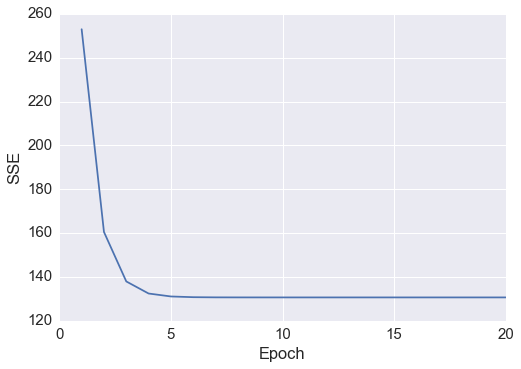

In [9]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [15]:
 def lin_regplot(X, y, model):
        plt.scatter(X, y, c='blue')
        plt.plot(X, model.predict(X), color='red')
        return None 

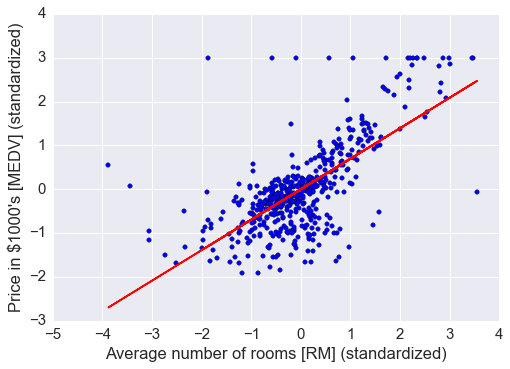

In [16]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

이 모델은 직관적으로 좋은 설명력을 가지긴 했지만 여전히 설명하지 못하는 집 가격들이 많다. 이 챕터 후반에는 regression model의 성능을 어떻게 정량화하는지에 대해 얘기할 것이다. 

아주 흥미롭게도, 우리는 y=3이 되는 지점에서 의문스러운 선을 발견할 수 있다. 

어떤 경우에는  스케일링을 하지 않은 오리지널 값으로 보고하는 것이 중요할 수도 있다. inverse_transform으로 다시 되돌리기

In [10]:
num_rooms_std = sc_x.transform([5.0])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" %  sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


C:\Users\성동\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


On a side note, it is also worth mentioning that we technically don't have to update the weights of the intercept if we are working with standardized variables since the  y axis intercept is always 0 in those cases. We can quickly confirm this by printing the weights:


In [11]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0]) 

Slope: 0.695
Intercept: -0.000


### Estimating the coefficient of a regression model via scikit-learn 

In [12]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_) 

Slope: 9.102
Intercept: -34.671


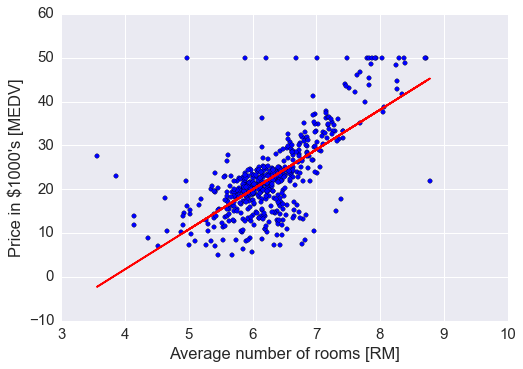

In [18]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

#### Fitting a robust regression model using RANSAC 

선형 모델은 아웃라이어들의 존재에 의해 강하게 영향을 받을 수 있다. 이 경우 아주 적은 부분집합의 데이터가 모델의 상관관계에 영향을 주게 된다. 

아웃라이어들을 탐지하는 여러 통계적 기법들이 있지만 이 책의 범위를 넘어서고 또한 아웃라이어들을 제거할 것인지 말 것인지는 항상 데이터 사이언티스트의 판단에 달려있다. (도메인..)

아웃라이어에 대처하는 한가지 대안은 RANdom SAmple Consensus (RANSAC) 알고리즘이다. 이 알고리즘은 데이터의 부분집합(inliers)으로 모델링을 한다.

1. inlier가 될 샘플의 숫자를 정하고 모델에 피팅한다.
2. 피팅된 모델에 다른 데이터들도 테스트 해보고 유저가 정한 범위 안에 들어가면 그 점들을 모두 추가한다.
3. 추가된 모든 inliers들을 사용하여 모델을 refit
4. fitted model과 inliers들의 에러를 측정
5. 사용자가 요구하는 퍼포먼스 충족하면 알고리즘 종료 아니면 1번 스텝으로

In [19]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                         residual_threshold=5.0, # 사용자가 정한 잔차의 범위가 5까지만 허용
                         random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, max_trials=100,
        min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x00000152D3B3B6A8>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

sklearn에서 기본적으로 제공하는 threshold는 MAD(Median Absolute Deviation)이지만 그 값은 problem-specific하다.

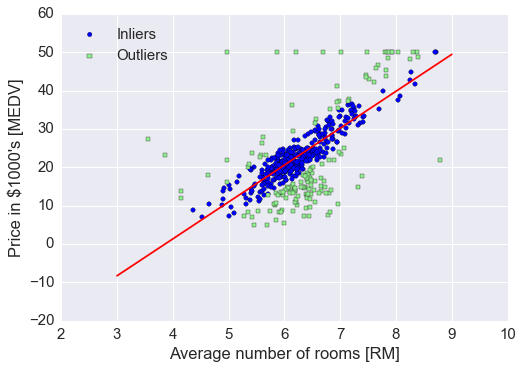

In [21]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [25]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 9.621
Intercept: -37.137


## Evaluating the performance of linear regression models 

In [22]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

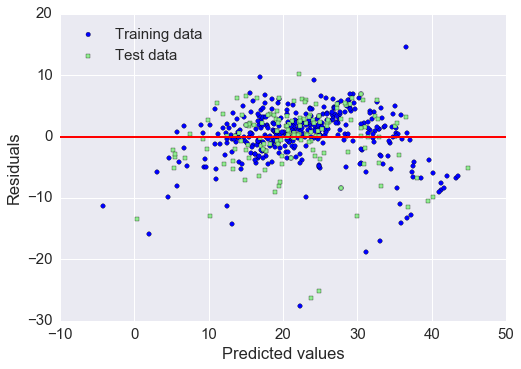

In [23]:
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

좋은 모델은 잔차가 랜덤하게 분포되어 이써야 하고 만약 어떠한 패턴이 있다면, 우리의 모델이 설명하는 정보에 문제가 있다는 뜻이다.

### Mean Squared Error (MSE) 

In [24]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


트레이닝 셋에 대한 에러가 19.96 정도 되고 테스트 셋 에러가 27.20 정도 된다는 것을 볼 수 있다

In [25]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred))) 

R^2 train: 0.765, test: 0.673


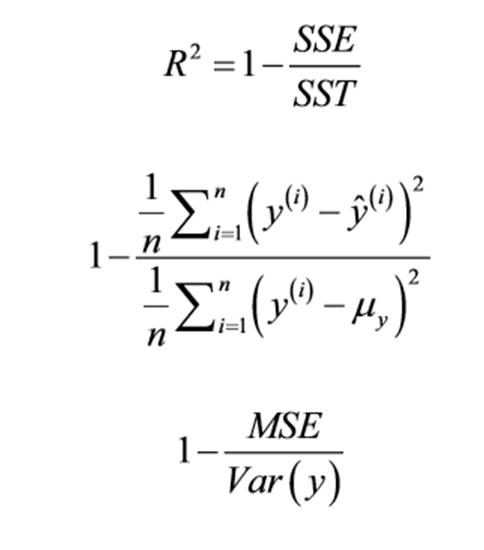

In [27]:
Image(filename='./image/image4.jpg', width=600) 

때때로는 MSE의 STANDARDIZED VERSION으로도 이해 할 수 있는 R^2를 사용하는 것이 유용하기도 하다.

이 R^2는 트레이닝셋에 있어서는 0에서 1 사이의 값을 가지지만 테스트 셋에 있어서는 음수값이 나올 수도 있다.

R^2 = 1이라는 소리는 MSE = 0 과 같다.

### Using regularized methods for regression

Ridge Regression, LASSO, Elastic Net

3장에서 Regularization에 대해 배웠었는데 이는 추가적 정보를 통해 과적합 문제를 해결하는 접근 법이었다. 

그 중 penalty를 추가해 파라미터에 제약을 가하는 방법인 weight decay 방법이 있었는데 가장 대중적인 접근인 Ridge, Least Absolute Shrinkage and Selection Operator(LASSO), Elastic Net 방법을 소개하겠다.

##### Ridge 

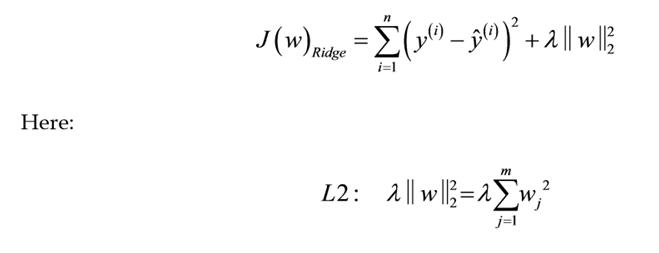

In [28]:
Image(filename='./image/image5.jpg', width=600) 

In [30]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0) # 초기화

##### LASSO

LASSO는 variable의 갯수 m보다 dataset의 갯수 n이 적으면 사용하지 못하는 제약이 있음.

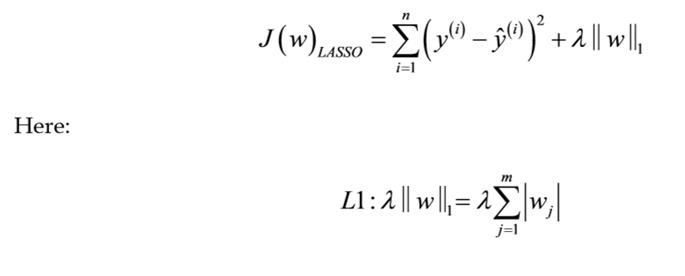

In [29]:
Image(filename='./image/image6.jpg', width=600) 

In [31]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0) 

##### ElasticNet

Ridge와 LASSO의 결합된 형태. L1 penaty는 sparsity를 생성하고 L2 penalty는 LASSO의 한계를 뛰어넘기 위해 같이 사용된다. 

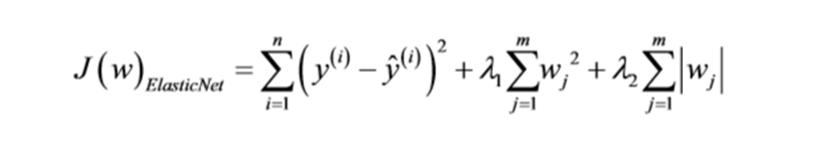

In [30]:
Image(filename='./image/image7.jpg', width=600) 

In [32]:
from sklearn.linear_model import ElasticNet
lasso = ElasticNet(alpha=1.0, l1_ratio=0.5)

### Turning a linear regression model into a curve - polynomial regression 

이 전까지는 우리의 설명 변수와 목표 변수가 선형적 관계를 가진다고 가정했었지만 이 선형적 가정을 깨는 여러 방법 중 하나는 다차항을 추가하는 것이다.

In [31]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0,
              320.0, 342.0, 368.0,
              396.0, 446.0, 480.0,
              586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8,
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [32]:
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

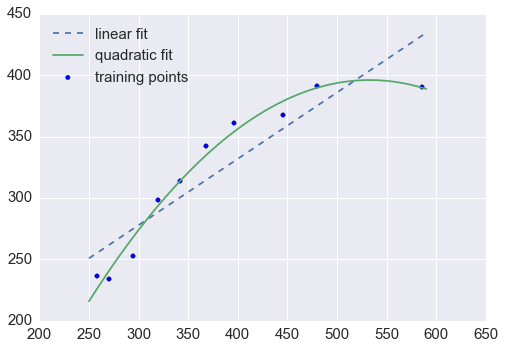

In [33]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit,
         label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit,
         label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [34]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330


In [35]:
print('Training  R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred))) 

Training  R^2 linear: 0.832, quadratic: 0.982


### Modeling nonlinear relationships in the Housing Dataset

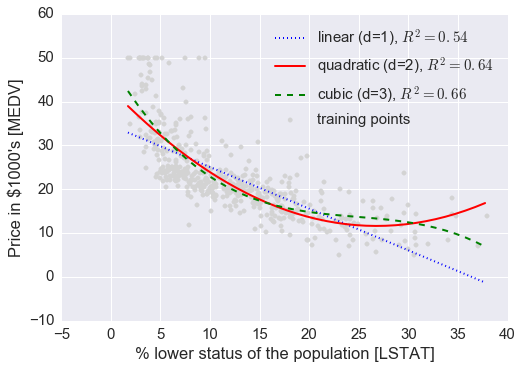

In [36]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# create polynomial features 
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear fit
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# quadratic fit
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# cubic fit
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results 
plt.scatter(X, y,
            label='training points',
            color='lightgray') 
plt.plot(X_fit, y_lin_fit,
         label='linear (d=1), $R^2=%.2f$' 
         % linear_r2, 
         color='blue',
         lw=2, 
         linestyle=':') 

plt.plot(X_fit, y_quad_fit,
         label='quadratic (d=2), $R^2=%.2f$' 
         % quadratic_r2, 
         color='red', 
         lw=2, 
         linestyle='-')

plt.plot(X_fit, y_cubic_fit,
         label='cubic (d=3), $R^2=%.2f$'
         % cubic_r2, 
         color='green', 
         lw=2, 
         linestyle='--') 

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show() 

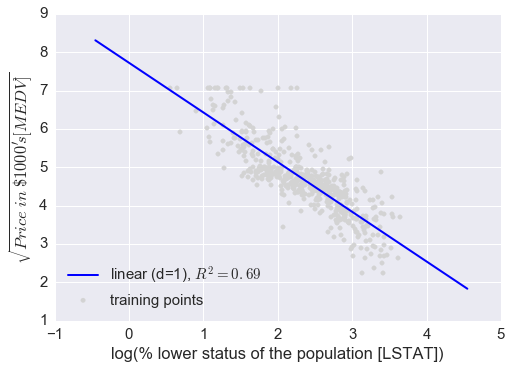

In [37]:
# transform features 
X_log = np.log(X)


y_sqrt = np.sqrt(y)
# fit features 
X_fit = np.arange(X_log.min()-1,
                  X_log.max()+1, 1)[:, np.newaxis] 
regr = regr.fit(X_log, y_sqrt) 
y_lin_fit = regr.predict(X_fit) 
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))
# plot results 
plt.scatter(X_log, y_sqrt,
            label='training points',
            color='lightgray')
plt.plot(X_fit, y_lin_fit,
         label='linear (d=1), $R^2=%.2f$' % linear_r2,
         color='blue',
         lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])') 
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$') 
plt.legend(loc='lower left') 
plt.show() 

### Dealing with nonlinear relationships using random forests 

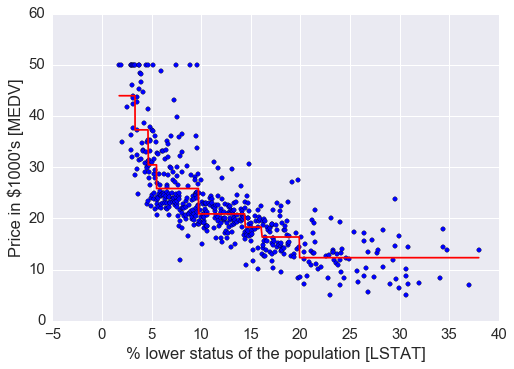

In [43]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

### Random Forest Regression

In [44]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(                             
    n_estimators=1000,
    criterion='mse',
    random_state=1,
    n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [45]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred))) 

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878
